In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from sdOB.utils.calEW import calEW
plt.style.use('lijiaostyle')

In [2]:
%config InlineBackend.figure_format='retina'

In [90]:
pwd

'/share/data/lijiao/Documents/sdOB/example/lan11/ipynb'

In [3]:
lamplists = glob('../data/LAN11_P200_SPEC/P200_LAMP/*0001.fits')
lampwlists = glob('../data/LAN11_P200_SPEC/P200_LAMP/*W.fits')

In [4]:
def read_p200_spec(fname, lamp=True):
    ''' read spectrum observed by P2000
    returns:
    ---------------
    wave
    flux
    fluxerr
    flux_norm
    flux_cont
    '''
    hdulist = fits.open(fname)
    date_keck = hdulist[0].header['UTSHUT']
    if lamp:
        flux = hdulist[0].data
    else:
        flux0=hdulist[0].data
        flux = flux0[0][0]
    temp=hdulist[0].header['CRVAL1']
    step=hdulist[0].header['CD1_1']
    wave = temp + np.arange(hdulist[0].header['NAXIS1'])*step
    #fluxerr = flux0[3][0]
    return wave, flux

def plotminmax(x, y, xmin=None, xmax=None, *arg, **kwargs):
    ind = np.ones(len(x), dtype=np.bool)
    if xmin is not None: ind = ind & (x > xmin)
    if xmax is not None: ind = ind & (x < xmax)
    plt.plot(x[ind], y[ind], *arg, **kwargs)
    
def plotvl(x0, dx, y):
    plt.plot([x0, x0+dx], [y, y], color='r', lw=2)

In [9]:
filelists = glob('../data/LAN11_P200_SPEC/recalibrate_wave/blue*.fits')
filelists.sort()
fname = '../data/LAN11_P200_SPEC/recalibrate_wave/blue0023_btfc_eblw_recalibrate_wave.fits'
wave, _ = read_p200_spec(fname)

lambfname = '../data/LAN11_P200_SPEC/P200_LAMP/blue0037_btfc_arc.0001.fits'
flux_lamp = fits.getdata(lambfname)

In [51]:
import joblib
arc_pyexspec_name = '../data/spec/P200_DBPS/20220219_rawdata/blue/dump_bgdeg2/lamp-blue0037.fits_for_blue0026.fits.dump'
arcdic = joblib.load(arc_pyexspec_name)
flux_arc_pyexspec = arcdic['flux_arc'][0][::-1]
wv_pyexspec = arcdic['wave_solu'][0][::-1]

In [52]:
hdulampw = fits.open(lampwlists[0])

In [53]:
lampwlists[0]

'../data/LAN11_P200_SPEC/P200_LAMP/blue0037_btfc_arcW.fits'

In [54]:
wv_w, flux_w = read_p200_spec(lampwlists[0])

Text(0.5, 0, 'Wavelength')

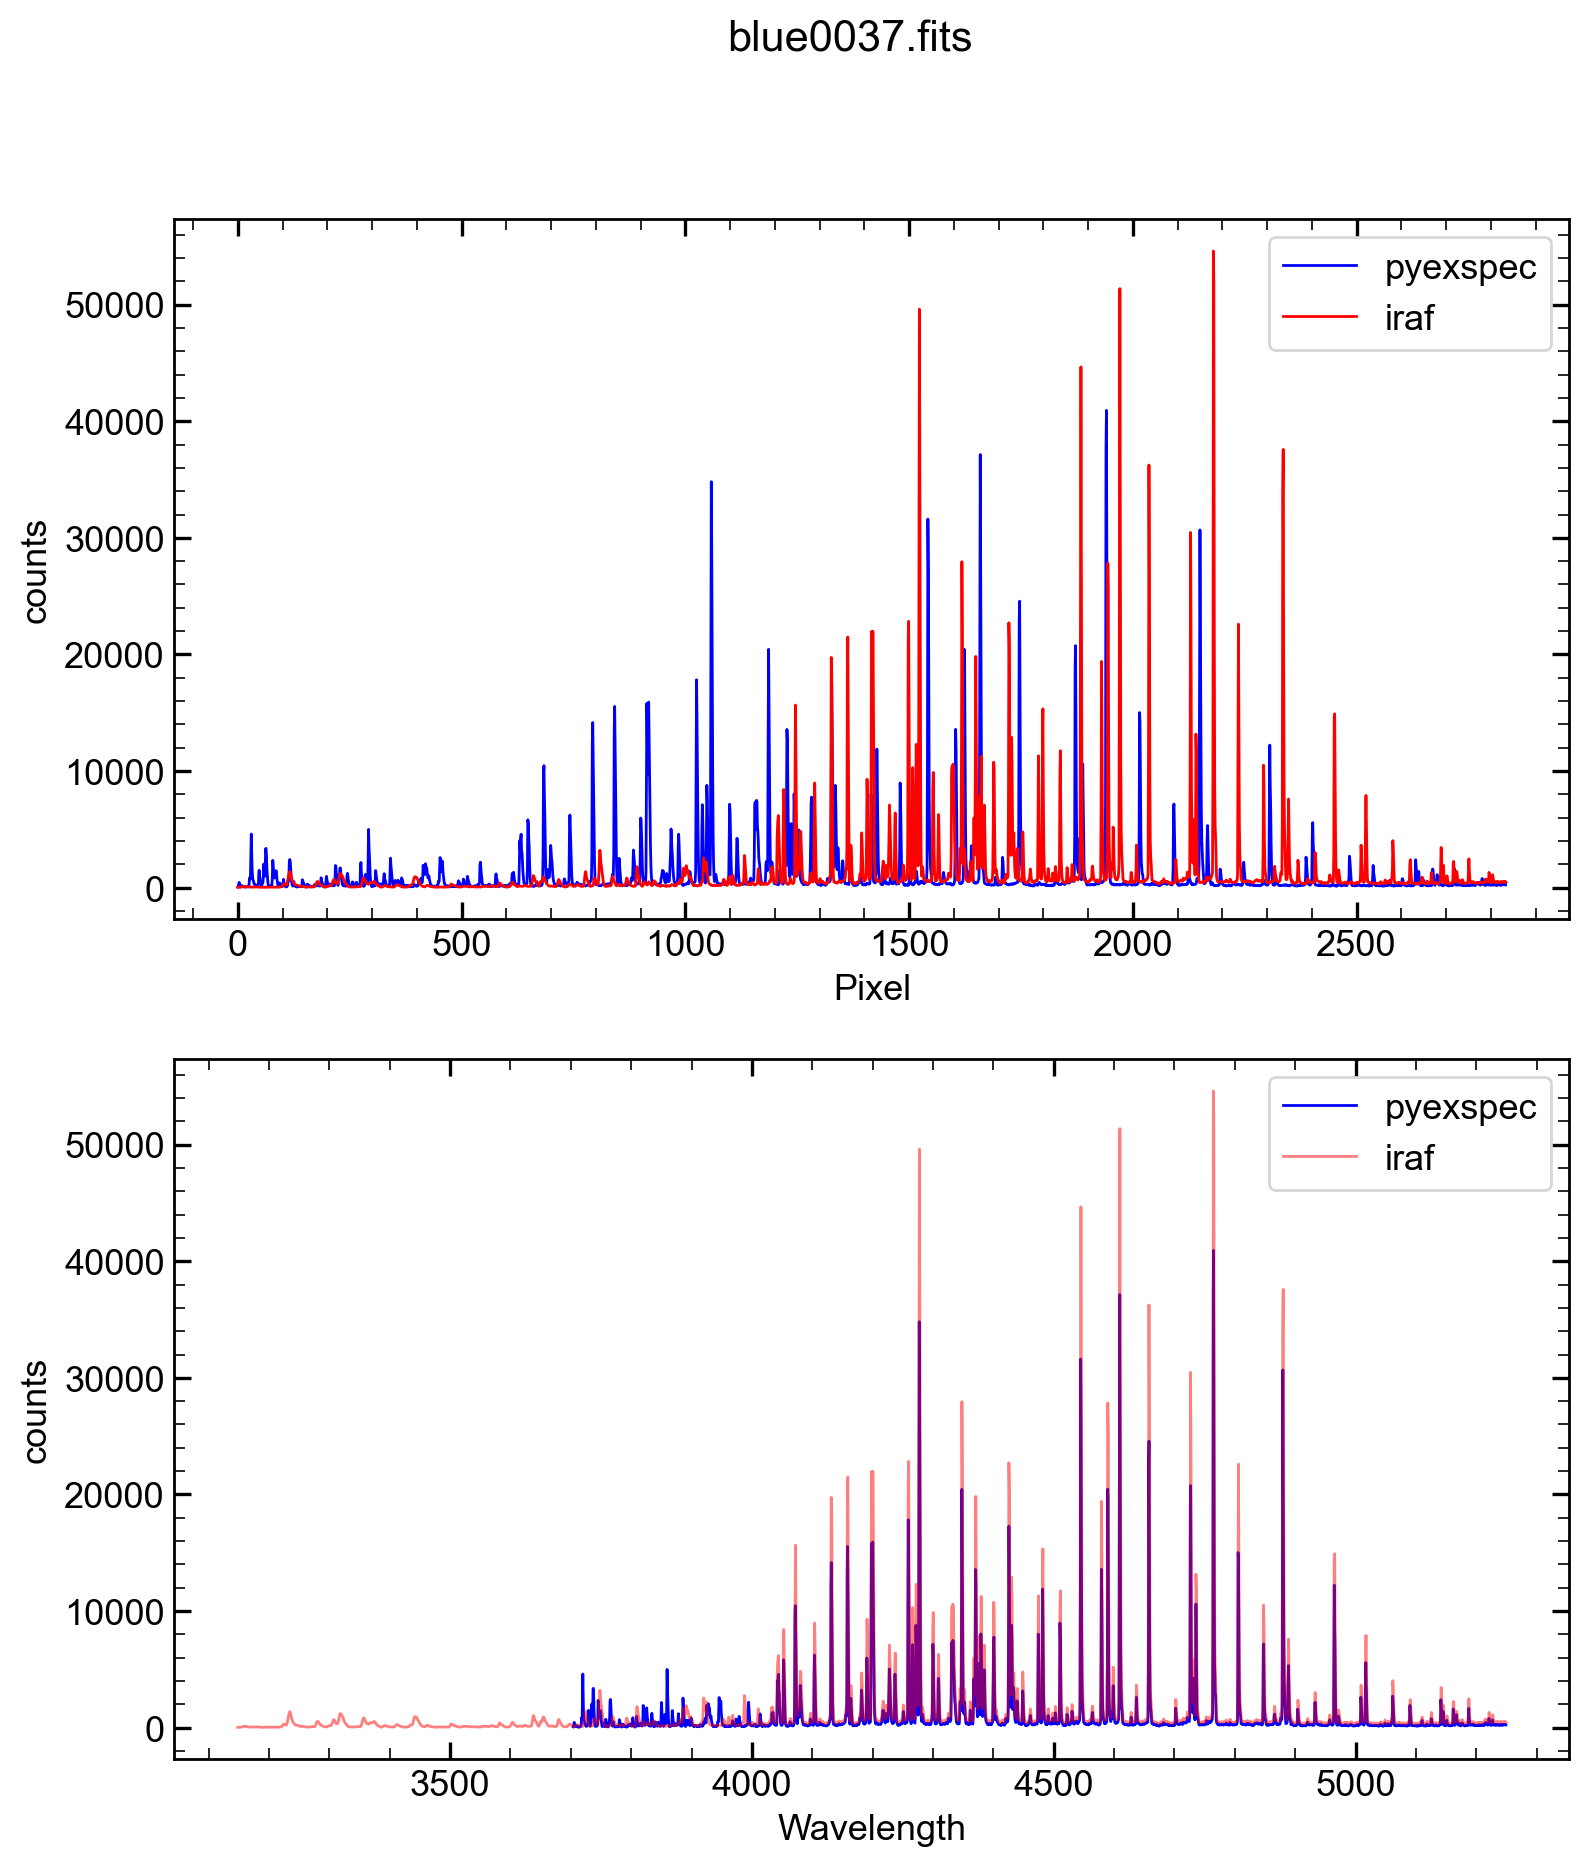

In [63]:
%matplotlib inline
fig, axs = plt.subplots(2,1, figsize=(9,10))
plt.suptitle('blue0037.fits')
plt.sca(axs[0])
plt.plot(flux_arc_pyexspec, label='pyexspec', color='b', lw=1)
plt.plot(flux_w, label='iraf', color='r', lw=1)
plt.legend()
plt.ylabel('counts')
plt.xlabel('Pixel')

plt.sca(axs[1])
plt.plot(wv_pyexspec, flux_arc_pyexspec, label='pyexspec', color='b', lw=1)
plt.plot(wv_w, flux_w, label='iraf', color='r', lw=1, alpha=0.5)
plt.legend()
plt.ylabel('counts')
plt.xlabel('Wavelength')


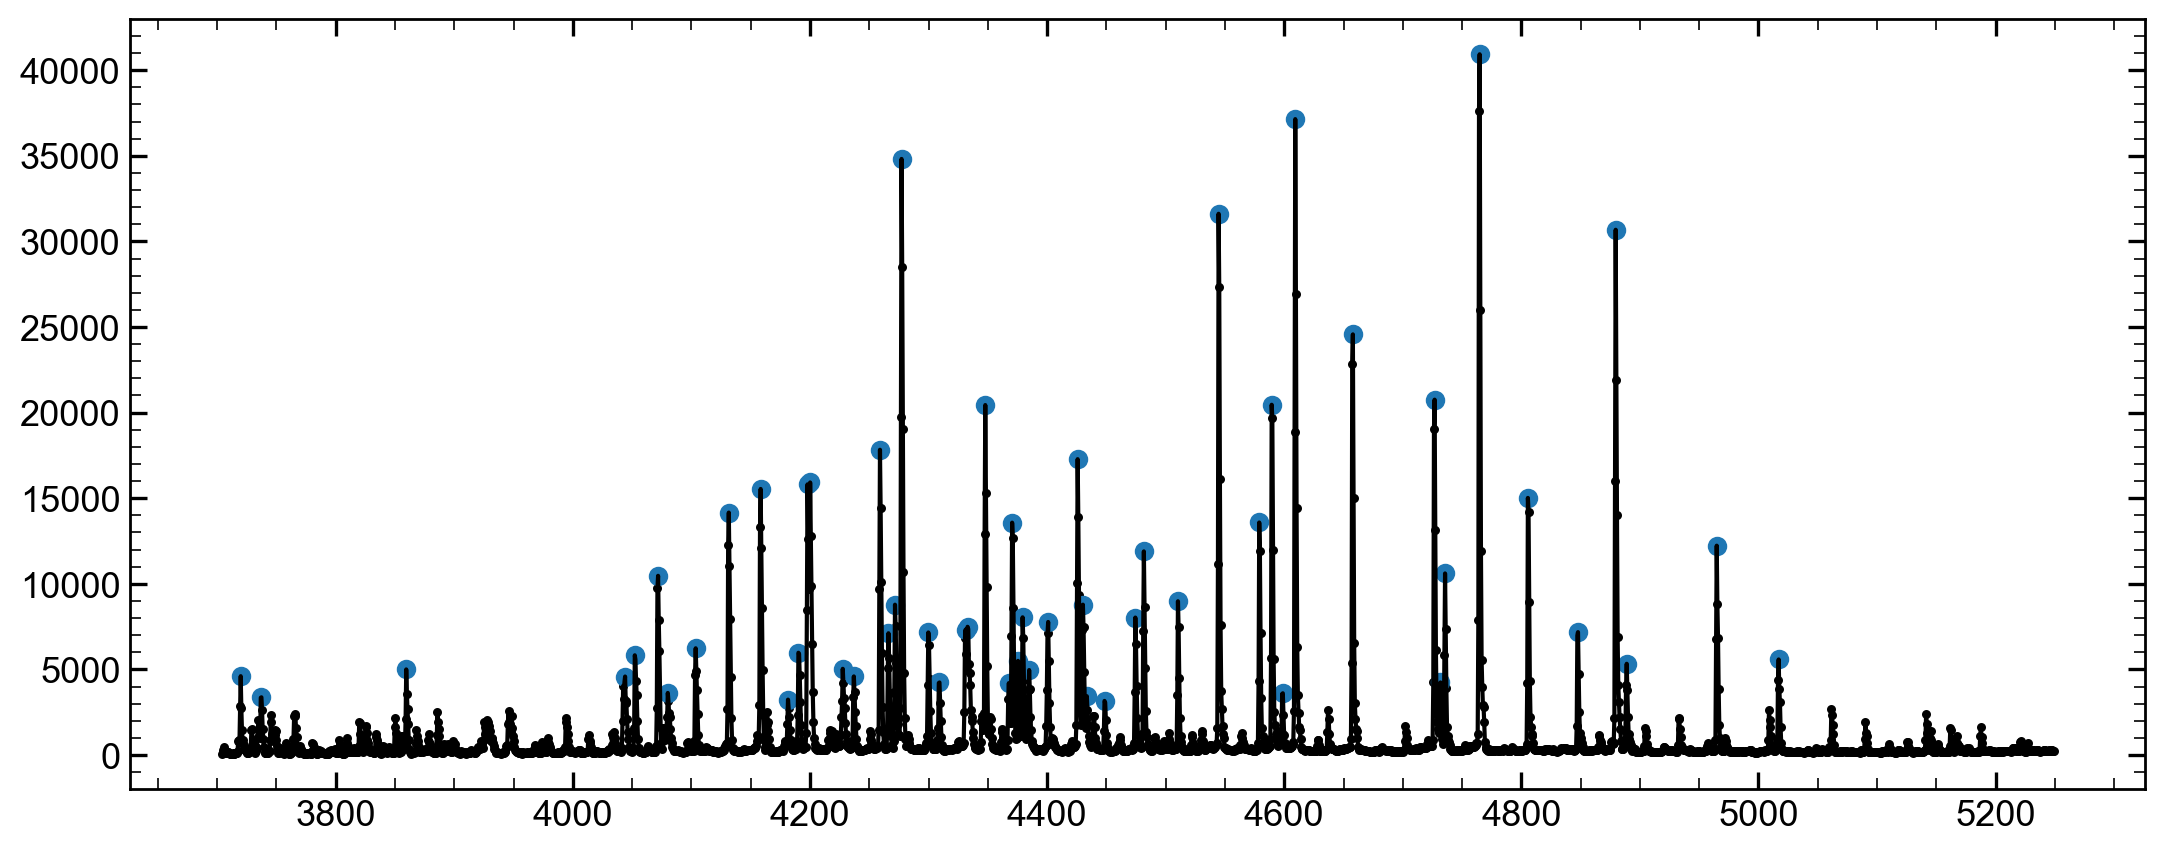

In [87]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
xmin = 4260
xmax = xmin+50
#plotminmax(wv_w, flux_w, xmin=xmin, xmax=xmax)
plt.plot(wv_pyexspec, flux_arc_pyexspec, color='k', label='p')
plt.scatter(wv_pyexspec, flux_arc_pyexspec, s=5, color='k')

index = argrelextrema(flux_arc_pyexspec, np.greater, order=2, mode='clip')[0]
#index = list(index)
_ind = flux_arc_pyexspec[index] > 3000
index_pyexspec = index[_ind]

plt.scatter(wv_pyexspec[index_pyexspec], flux_arc_pyexspec[index_pyexspec])

Text(4277.6, 25000, '1.7 $\\AA$')

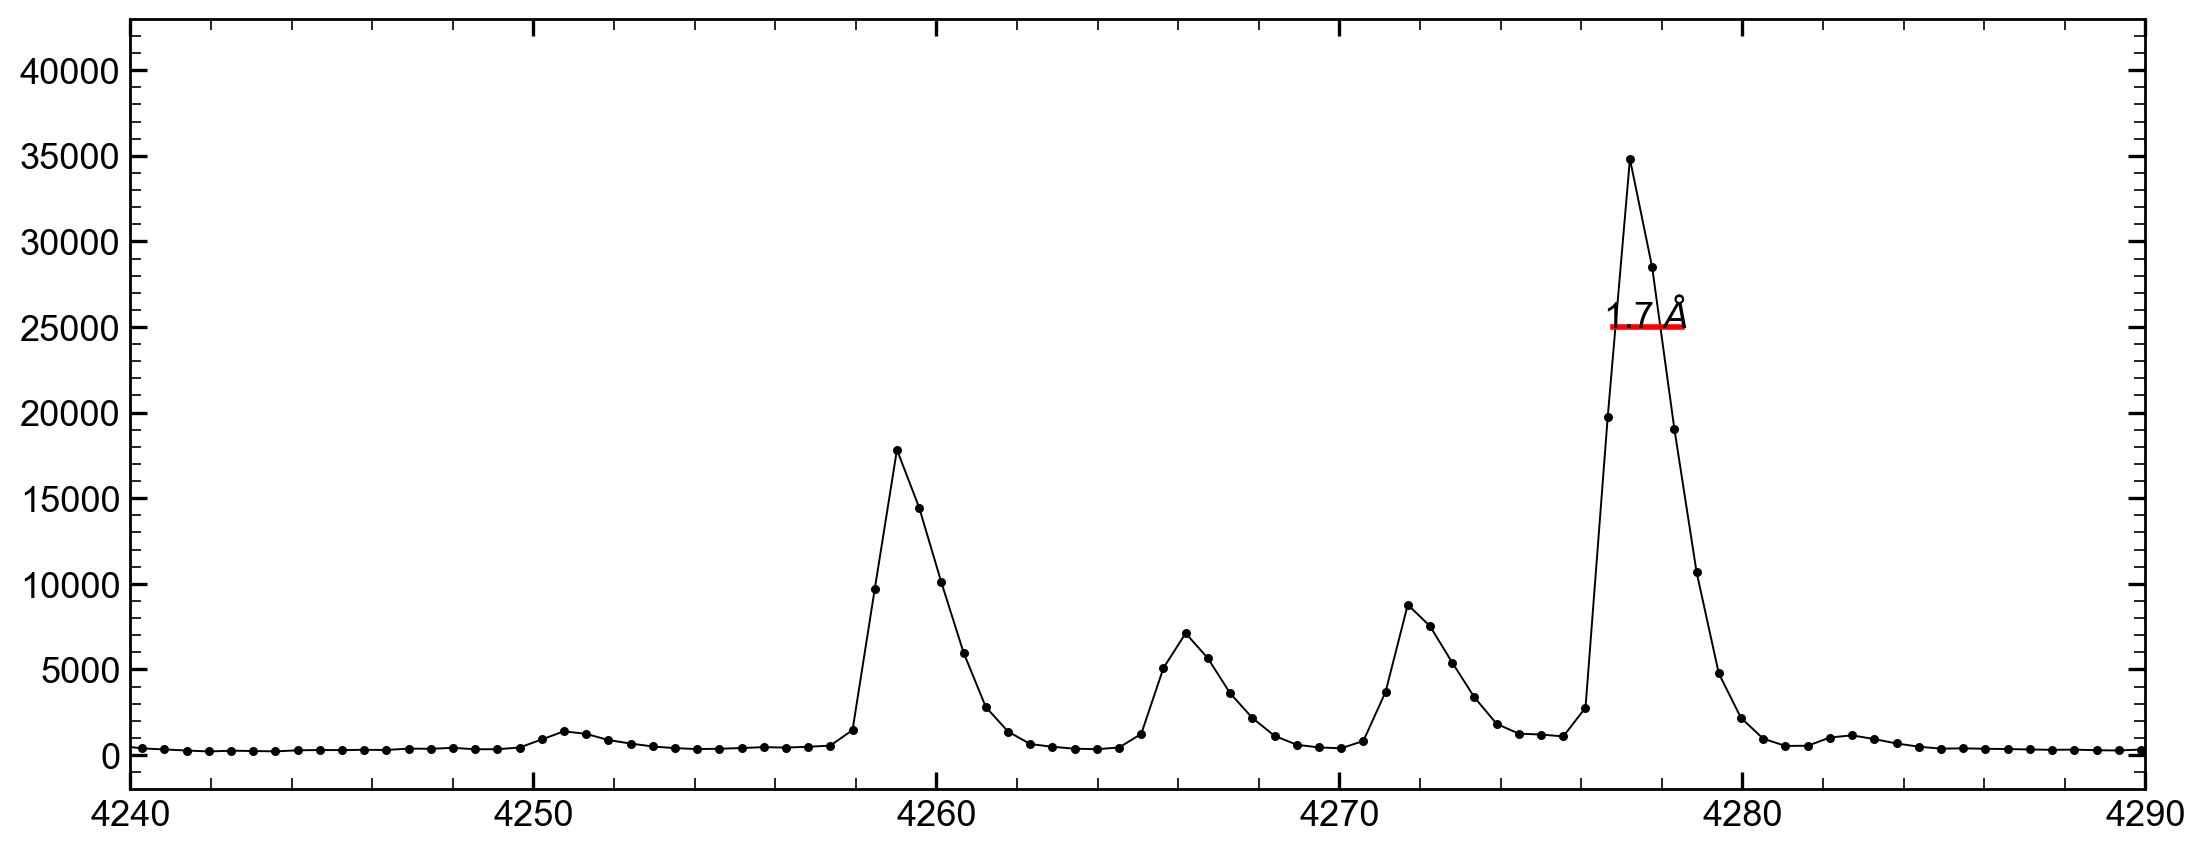

In [70]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
xmin = 4240
xmax = xmin+50
#plotminmax(wv_w, flux_w, xmin=xmin, xmax=xmax)
plt.plot(wv_pyexspec, flux_arc_pyexspec, color='k', lw=0.7)
plt.scatter(wv_pyexspec, flux_arc_pyexspec, s=5, color='k')
plt.xlim(xmin, xmax)
#plt.plot([4276.65, 4278.65], [25000, 25000], color='r', lw=2)
plotvl(4276.8, 1.7, 25000)
plt.text(4277.6, 25000, r'1.7 $\AA$', ha='center')

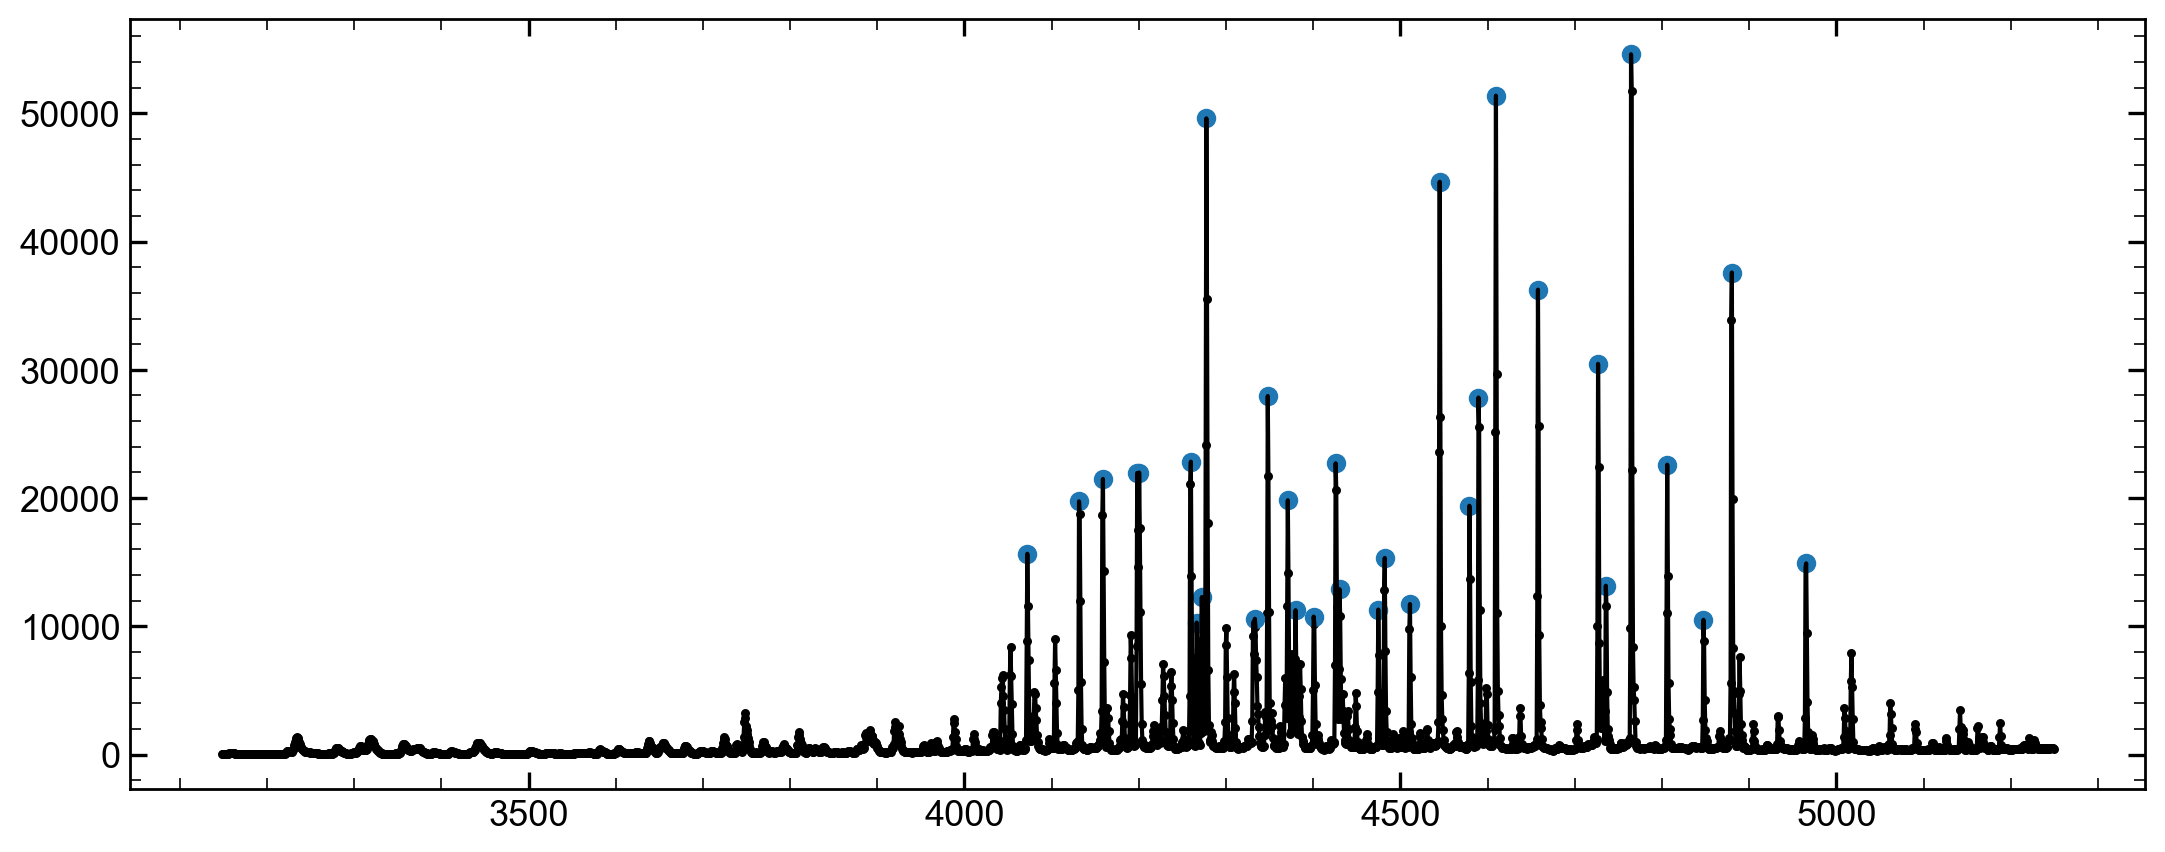

In [71]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
xmin = 4260
xmax = xmin+50
#plotminmax(wv_w, flux_w, xmin=xmin, xmax=xmax)
plt.plot(wv_w, flux_w, color='k')
plt.scatter(wv_w, flux_w, s=5, color='k')

index = argrelextrema(flux_w, np.greater, order=2, mode='clip')[0]
#index = list(index)
_ind = flux_w[index] > 10000
index = index[_ind]

plt.scatter(wv_w[index], flux_w[index])
#plt.xlim(xmin, xmax)

In [72]:
class findlamda(calEW):
      
      def __init__(self, x, y):
        self.x = x
        self.y = y
        
      def getpopt(self, index, dindex=9, sigma0 = 1.7, show=False):
        x = self.x[index-dindex:index+dindex]
        y = self.y[index-dindex:index+dindex]
        p0 = [self.y[index], self.x[index], sigma0, 0, 0]
        popt, pcov = self.fit_func(x, y, p0, func=self.gauss_linear, inters=3)
        xdens = np.linspace(x[0], x[-1], 1000)
        ydens = self.gauss_linear(xdens, *popt)
        self.popt = popt
        self.pcov = pcov
        self.x_lambda = x - popt[1]
        self.y_norm = (y - popt[-1] - popt[-2]*x)/popt[0]
        if show:
            plt.plot(x,y)
            plt.plot(xdens, ydens)

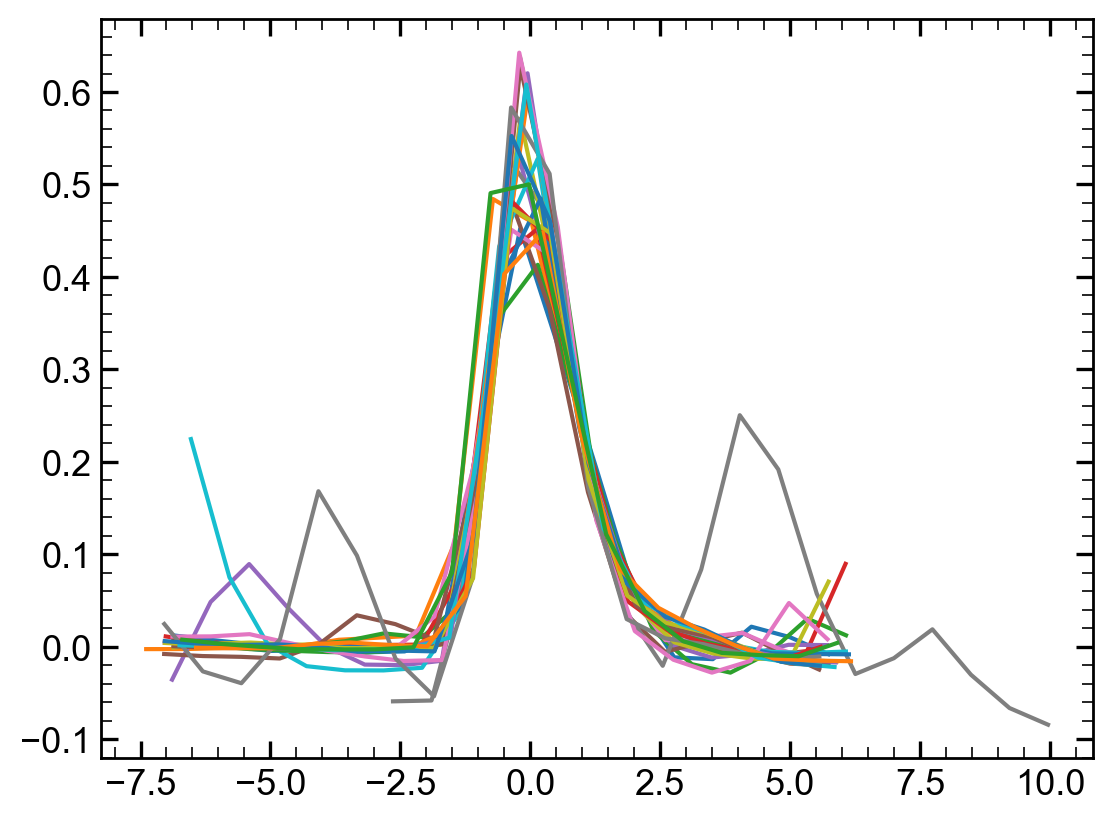

In [74]:
index[[0,1,2]]

array([1246, 1326, 1363])

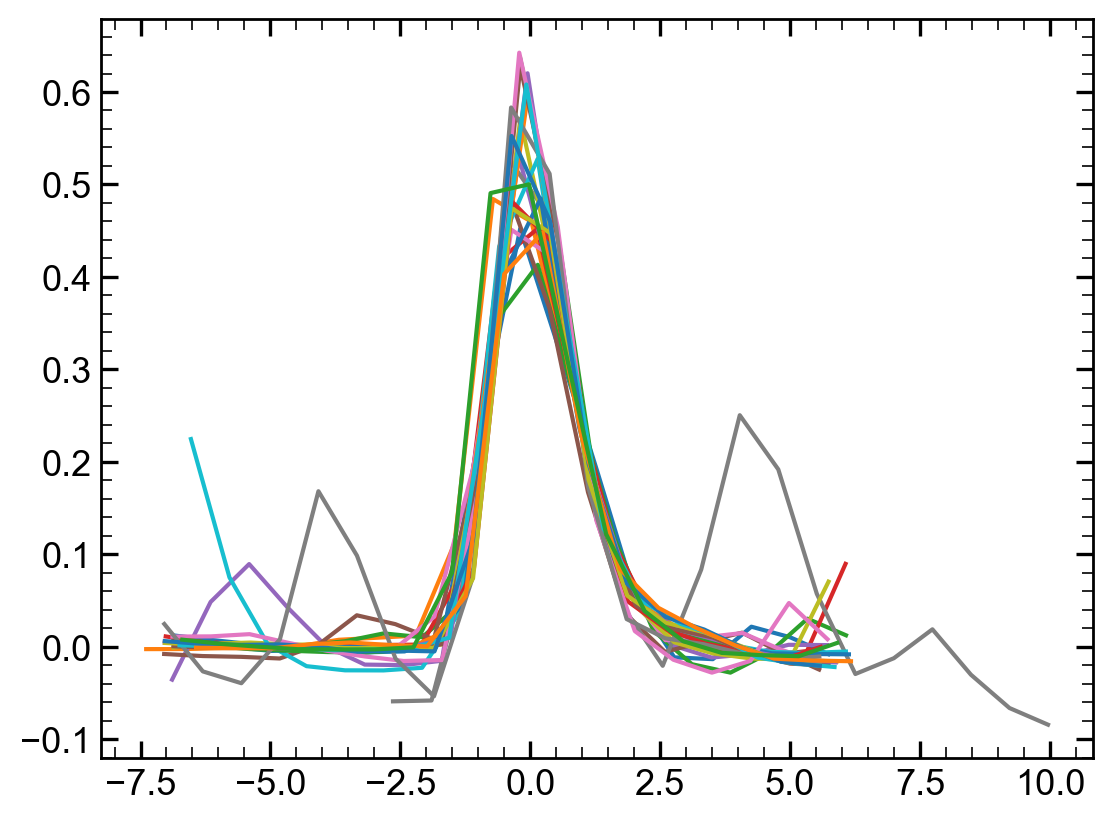

sigma = 0.7241022599496961
fwhm = 1.7051305163817556


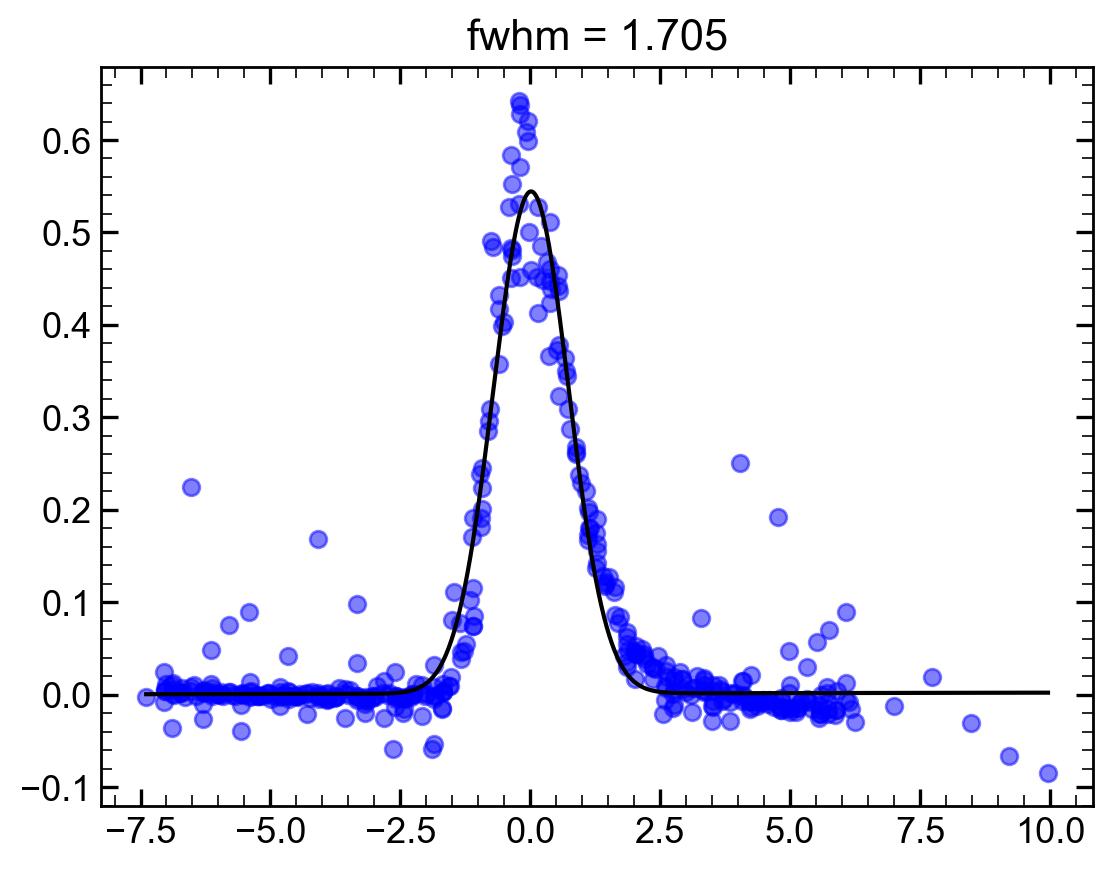

In [80]:
#[0,3,4,5, 6,7,8, 9,10, 11,12, 13, 14]
x = []
y = []
plt.subplots(1,1)
flambda = findlamda(wv_w, flux_w)
for _ind in index[[0,1, 2,5,6, 7, 8,10,11, 12, 13, 14, 15,16, 17, 18, 19,20, 21, 22, 23, 24, 25,26,27, 28,29,30]]:
    try:
        flambda.getpopt(_ind)
        if flambda.popt[0] < 0: continue
        if flambda.popt[2] > 2: continue
        plt.plot(flambda.x_lambda, flambda.y_norm)
        x.append(flambda.x_lambda)
        y.append(flambda.y_norm)
    except: pass
x = np.hstack(x)
y = np.hstack(y)
plt.show()


_ind = np.argsort(x)
x = x[_ind]
y = y[_ind]
p0=[0.5, 0, 1.7, 0, 0]
popt, pcov =flambda.fit_func(x, y, p0, func=flambda.gauss_linear, inters=3, percentile=99) #curve_fit(flambda.gauss_linear, x, y, p0=[0.5, 0, 1.7, 0, 0])
xdens = np.linspace(x[0], x[-1], 1000)
ydens = flambda.gauss_linear(xdens, *popt)
plt.subplots(1,1)
plt.scatter(x, y, color='b', alpha=0.5)
plt.plot(xdens, ydens, color='k')

sigma = popt[2]
fwhm = sigma*2*np.sqrt(-2.0*np.log(0.5))
print(f'sigma = {popt[2]}')
print(f'fwhm = {fwhm}')
plt.title(f'fwhm = {fwhm:.3f}')
plt.show()

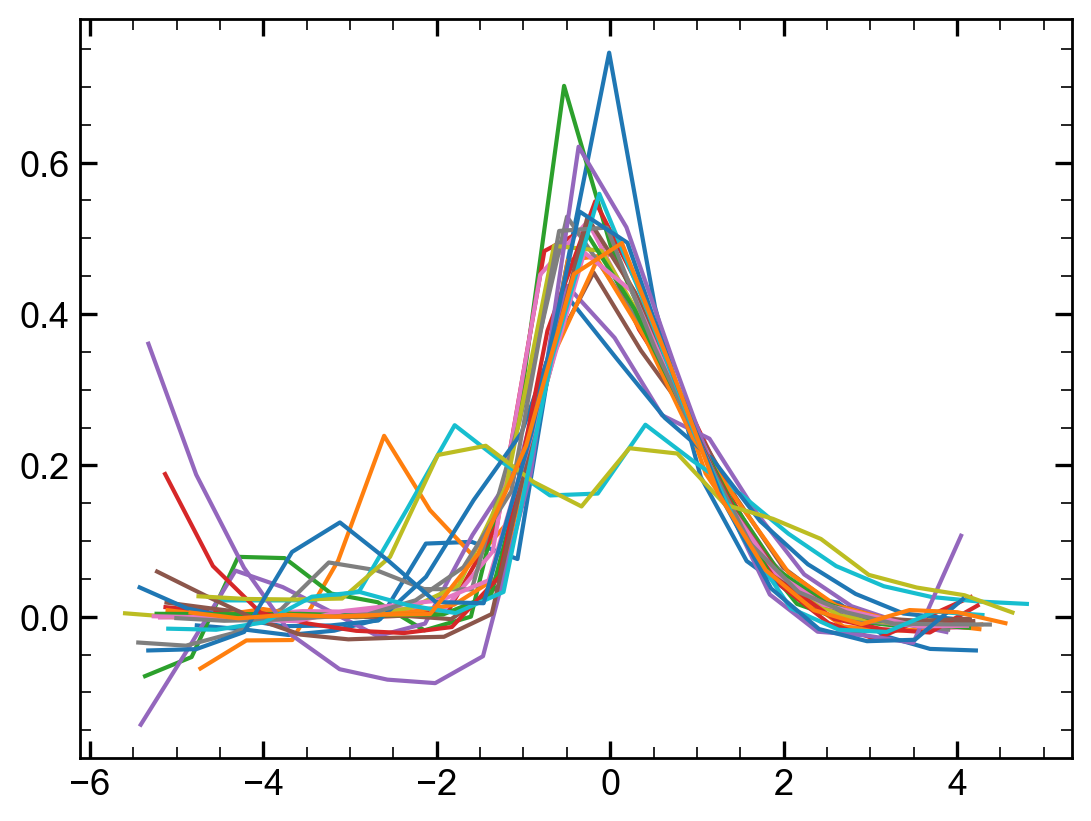

sigma = 0.7991789599267648
fwhm = 1.8819226344025315


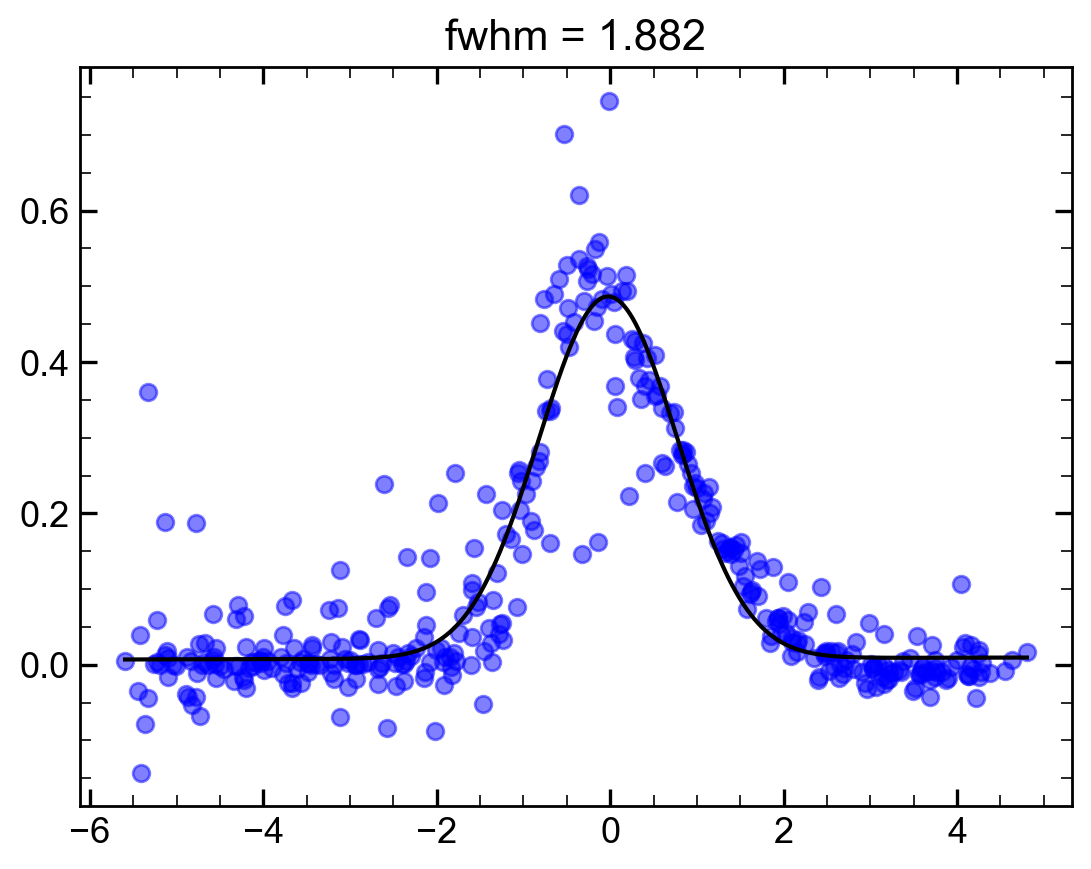

In [88]:
#[0,3,4,5, 6,7,8, 9,10, 11,12, 13, 14]
x = []
y = []
plt.subplots(1,1)
flambda = findlamda(wv_pyexspec, flux_arc_pyexspec)
for _ind in index_pyexspec[[0,1, 2,5,6, 7, 8,10,11, 12, 13, 14, 15,16, 17, 18, 19,20, 21, 22, 23, 24, 25,26,27, 28,29,30]]:
    try:
        flambda.getpopt(_ind)
        if flambda.popt[0] < 0: continue
        if flambda.popt[2] > 2: continue
        plt.plot(flambda.x_lambda, flambda.y_norm)
        x.append(flambda.x_lambda)
        y.append(flambda.y_norm)
    except: pass
x = np.hstack(x)
y = np.hstack(y)
plt.show()


_ind = np.argsort(x)
x = x[_ind]
y = y[_ind]
p0=[0.5, 0, 1.7, 0, 0]
popt, pcov =flambda.fit_func(x, y, p0, func=flambda.gauss_linear, inters=3, percentile=99) #curve_fit(flambda.gauss_linear, x, y, p0=[0.5, 0, 1.7, 0, 0])
xdens = np.linspace(x[0], x[-1], 1000)
ydens = flambda.gauss_linear(xdens, *popt)
plt.subplots(1,1)
plt.scatter(x, y, color='b', alpha=0.5)
plt.plot(xdens, ydens, color='k')

sigma = popt[2]
fwhm = sigma*2*np.sqrt(-2.0*np.log(0.5))
print(f'sigma = {popt[2]}')
print(f'fwhm = {fwhm}')
plt.title(f'fwhm = {fwhm:.3f}')
plt.show()

In [89]:
4500/1.882

2391.073326248672

Text(4277.6, 25000, '1.7 $\\AA$')

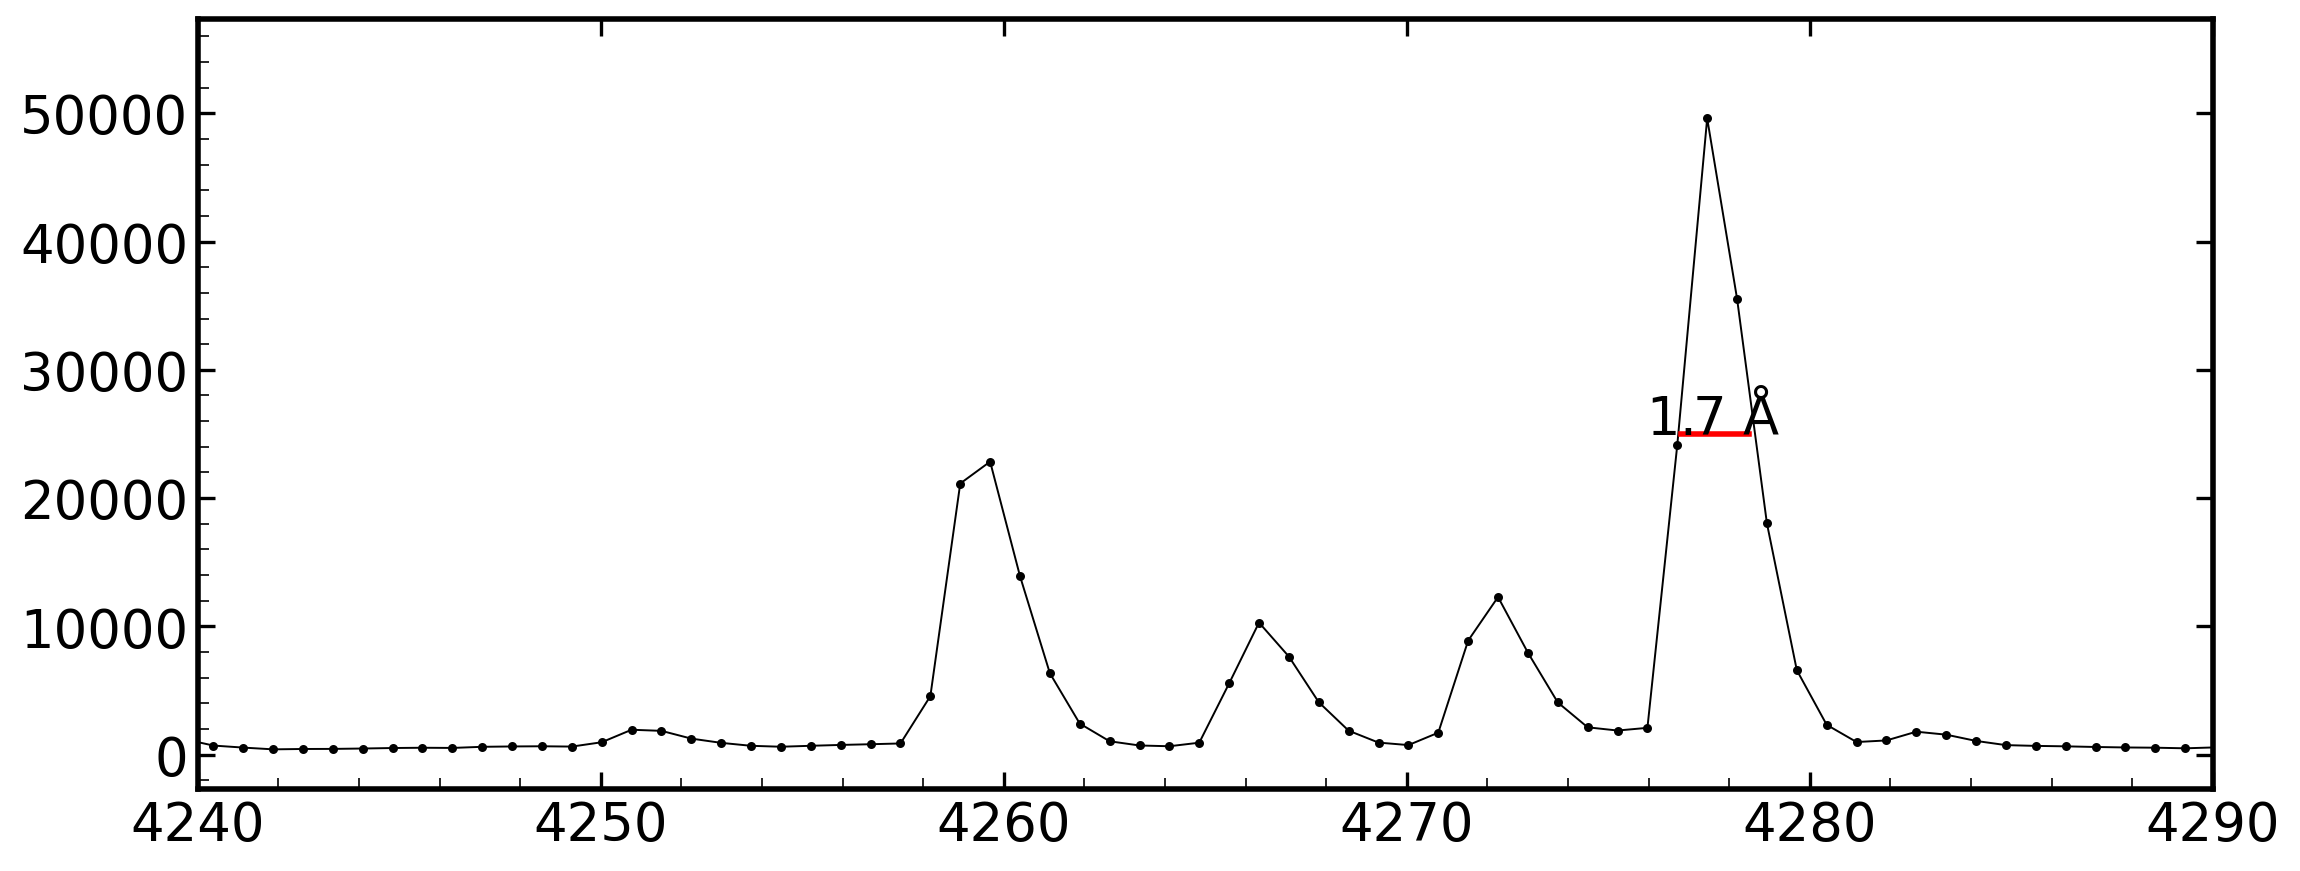

In [153]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
xmin = 4240
xmax = xmin+50
#plotminmax(wv_w, flux_w, xmin=xmin, xmax=xmax)
plt.plot(wv_w, flux_w, color='k', lw=0.7)
plt.scatter(wv_w, flux_w, s=5, color='k')
plt.xlim(xmin, xmax)
#plt.plot([4276.65, 4278.65], [25000, 25000], color='r', lw=2)
plotvl(4276.8, 1.7, 25000)
plt.text(4277.6, 25000, r'1.7 $\AA$', ha='center')

(4500.0, 4700.0)

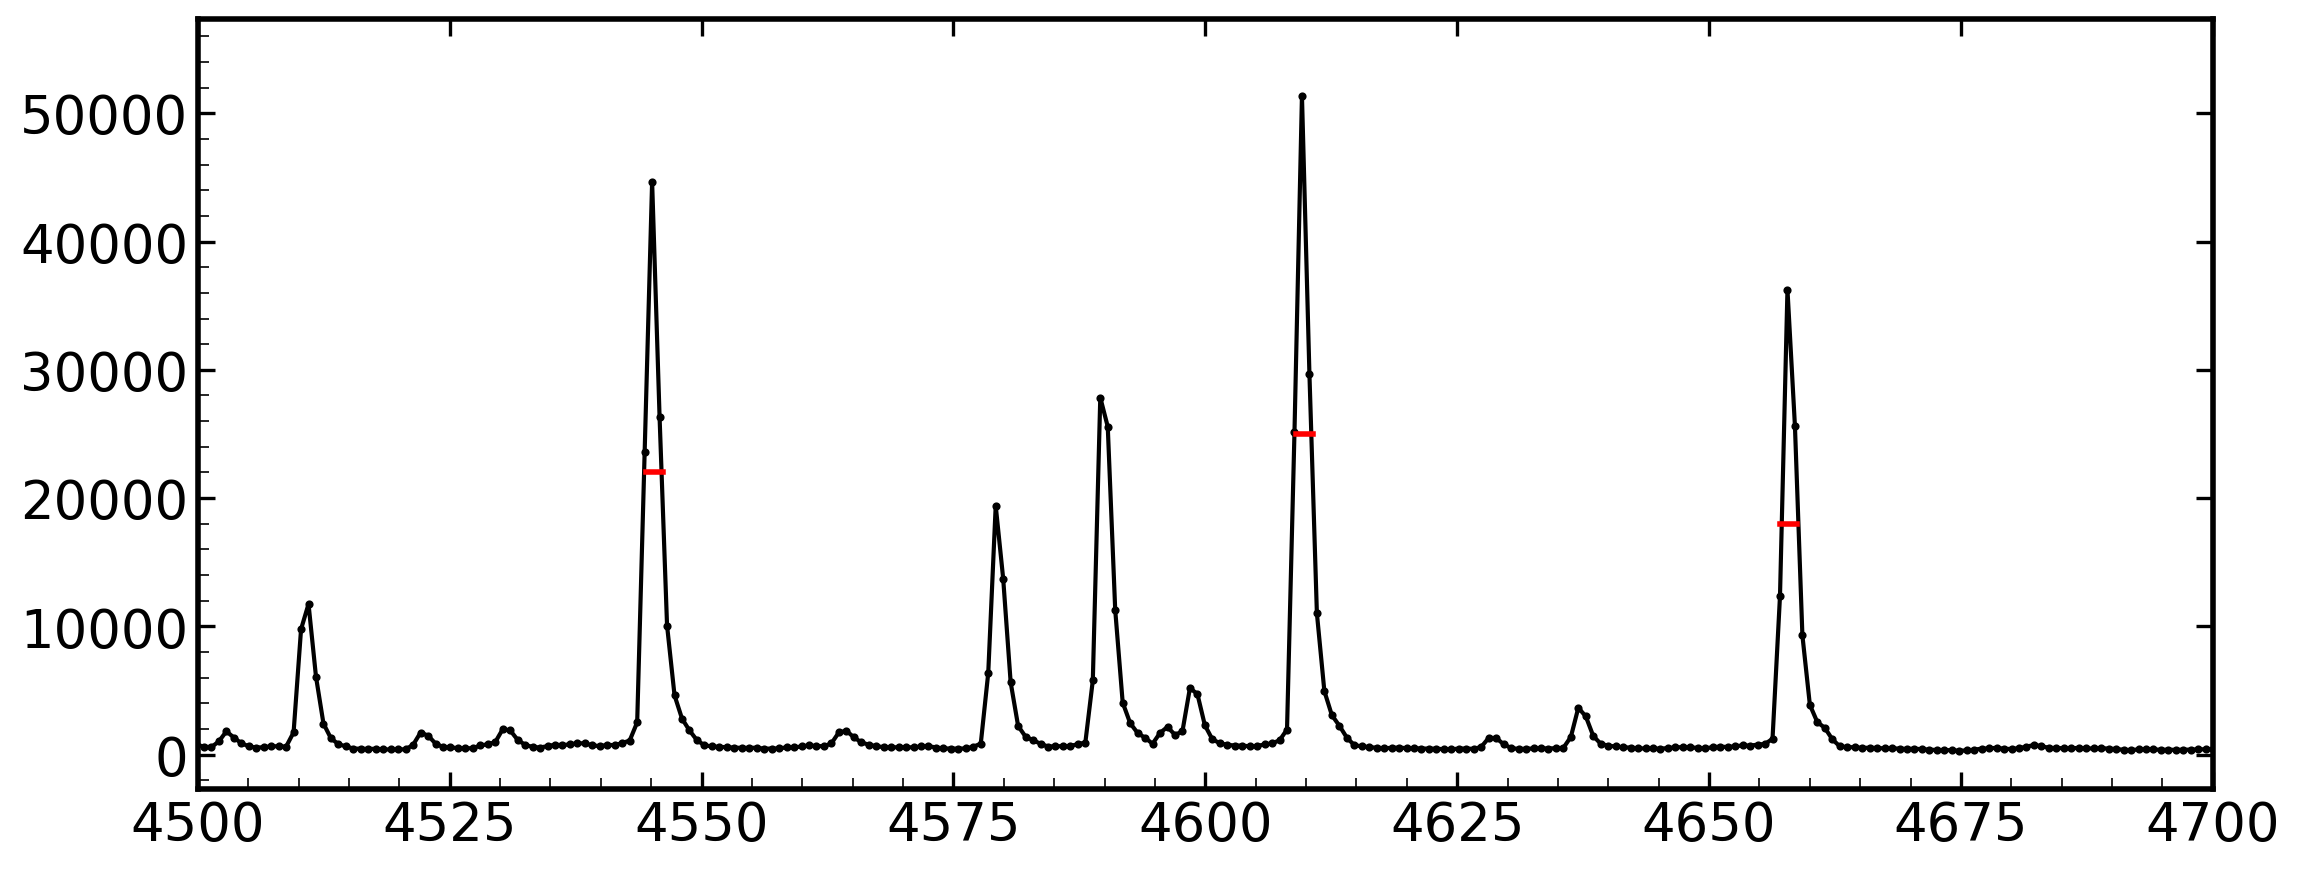

In [154]:
fig, ax = plt.subplots(1,1, figsize=(13,5))
xmin = 4500
xmax = xmin+200
#plotminmax(wv_w, flux_w, xmin=xmin, xmax=xmax)
plt.plot(wv_w, flux_w, color='k')
plt.scatter(wv_w, flux_w, s=5, color='k', lw=0.7)

plotvl(4544.5, 1.7, 22000)
plotvl(4609, 1.7, 25000)
plotvl(4657, 1.7, 18000)
plt.xlim(xmin, xmax)

In [156]:
hdulampw[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 2835 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2022-05-20T02:07:10' / Date FITS file was generated                  
IRAF-TLM= '2022-05-20T02:07:10' / Time of last modification                     
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
OBJECT  = 'FeAr    '        